In [189]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [190]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [191]:
df_result_accuracy = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'accuracy'])
df_result_rmse = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'rmse'])

In [192]:
geo = pd.read_csv('../datasets/socio.csv')
columns = ['sex', 'relation', 'is_parent', 'has_pets', 'age', 'mean_tr', 'median_tr', 'tr_per_month']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [193]:
geo['age'] = geo['age'].apply(lambda x: float(x))
geo['sex'] = geo['sex'].apply(lambda x: str(x))
geo['relation'] = geo['relation'].apply(lambda x: str(x))
geo['is_parent'] = geo['is_parent'].apply(lambda x: str(x))
geo['has_pets'] = geo['has_pets'].apply(lambda x: str(x))

In [194]:
geo_train, geo_test = train_test_split(geo, test_size=0.1)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [195]:
geo_types = get_nodes_type(geo)
geo_types

{'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'cont',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 'tr_per_month': 'cont'}

In [196]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [197]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

# Hill Climbing

# Дискретная структра + смешанные параметры

In [198]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_types)

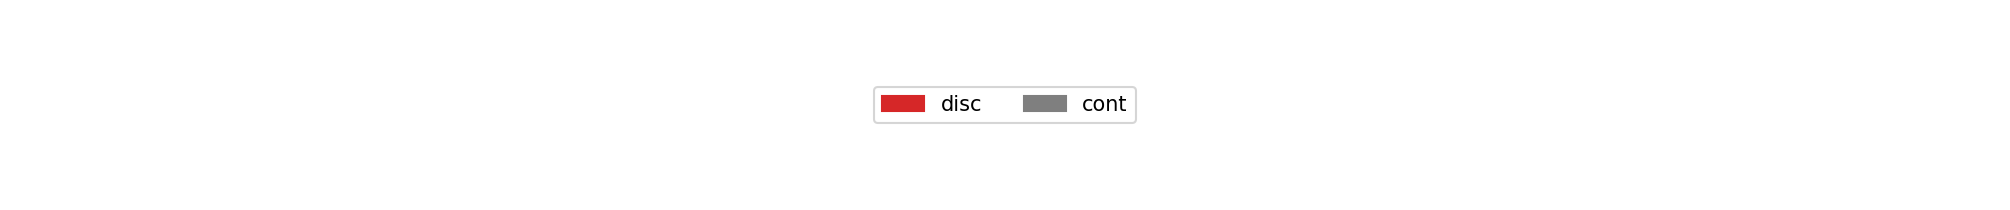

In [199]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [200]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [201]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [202]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

In [203]:
acc

{'sex': 0.6, 'relation': 0.22, 'is_parent': 0.74, 'has_pets': 0.95}

In [204]:
rmse

{'age': 12.42, 'mean_tr': 6991.93, 'median_tr': 6303.62, 'tr_per_month': 19.0}

In [205]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [206]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:260: RuntimeWarning: overflow encountered in double_scalars
  delta_score = delta1 + delta2
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-

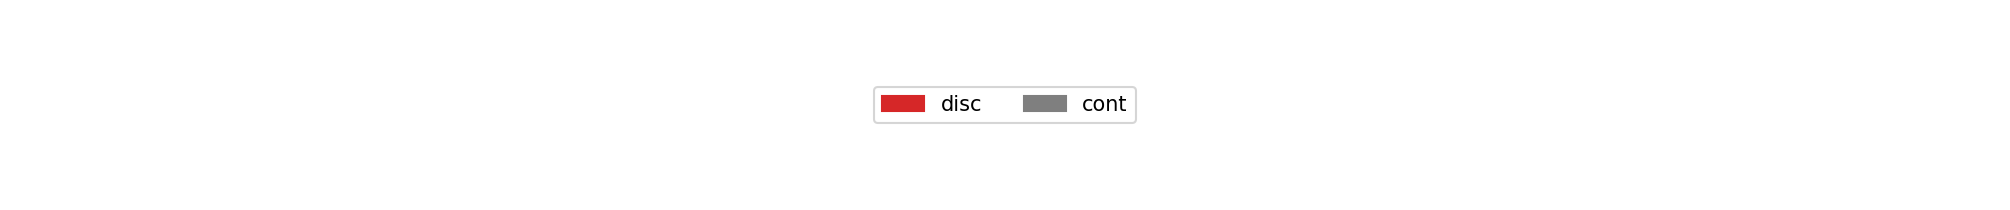

In [207]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [208]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [209]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [210]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

In [211]:
acc

{'sex': 0.6, 'relation': 0.22, 'is_parent': 0.74, 'has_pets': 0.95}

In [212]:
rmse

{'age': 12.44, 'mean_tr': 6887.79, 'median_tr': 6291.7, 'tr_per_month': 18.99}

In [213]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная стурктура + дискретные параметры

In [214]:
geo_new_types = {'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'disc',
 'mean_tr': 'disc',
 'median_tr': 'disc',
 'tr_per_month': 'disc'}

In [215]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_new_types)

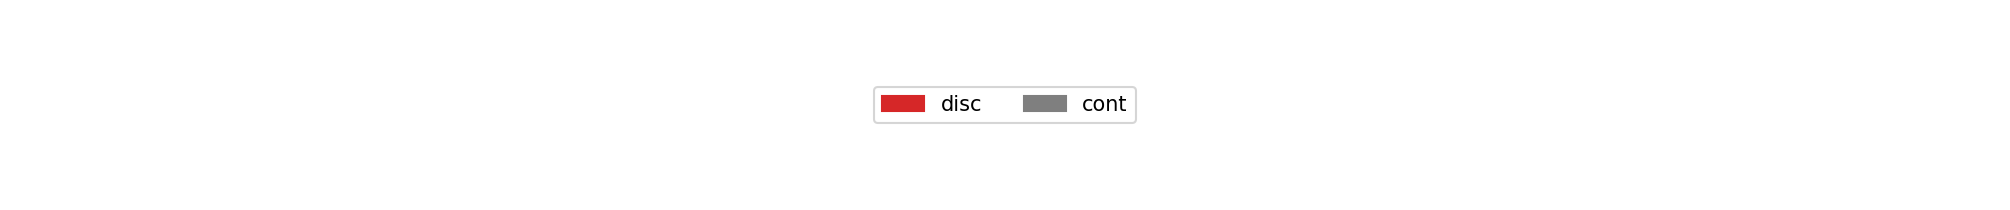

In [216]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [217]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [218]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [219]:
test_discrete = copy(geo_test)

In [220]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [221]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,sex,relation,is_parent,has_pets,age,mean_tr,median_tr,tr_per_month
0,1,7,1,0,2,3,3,3
1,2,4,1,0,3,0,0,4
2,1,7,0,0,0,0,0,1
3,2,6,0,0,1,0,1,3
4,2,1,0,0,0,2,1,3
...,...,...,...,...,...,...,...,...
374,1,6,1,0,1,2,2,2
375,2,1,0,0,1,1,0,3
376,1,6,0,0,0,0,0,1
377,2,7,0,0,1,0,0,2


In [222]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [223]:
acc

{'sex': 0.61,
 'relation': 0.23,
 'is_parent': 0.74,
 'has_pets': 0.95,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [224]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [225]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [226]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age','mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [227]:
m = mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'age', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [228]:
m = mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'mean_tr', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [229]:
m = mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'median_tr', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [230]:
m = mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'tr_per_month', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [231]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_new_types)

c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:260: RuntimeWarning: overflow encountered in double_scalars
  delta_score = delta1 + delta2
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-

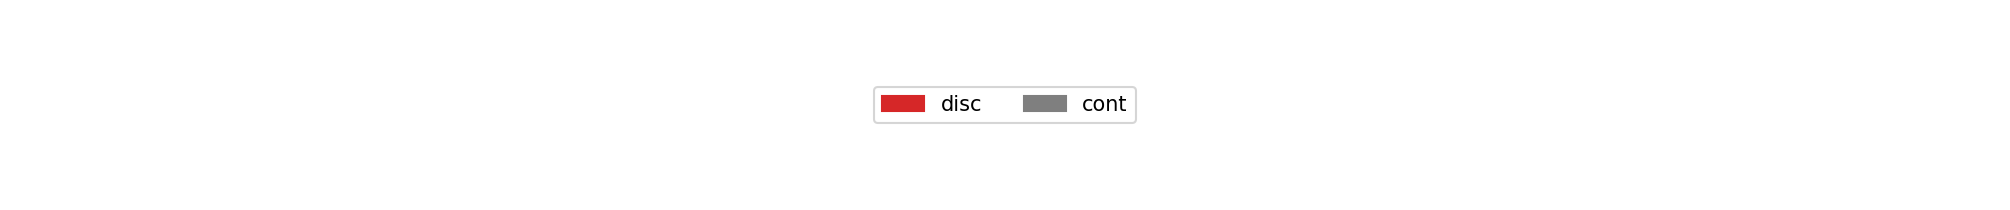

In [232]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [233]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [234]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [235]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [236]:
acc

{'sex': 0.6,
 'relation': 0.22,
 'is_parent': 0.74,
 'has_pets': 0.95,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [237]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [238]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [239]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [240]:
m = mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'age', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [241]:
m = mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'mean_tr', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [242]:
m = mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'median_tr', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [243]:
m = mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'tr_per_month', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

# EVO

# Дискретная стурктура + смешанные параметры

In [244]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 6.654599999999999
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 5.1177
Generation num: 1
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 5.1177
Generation num: 2
max_depth: 3, no improvements: 1
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 5.1177
Generation num: 3
max_depth: 3, no improvements: 2
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.3 

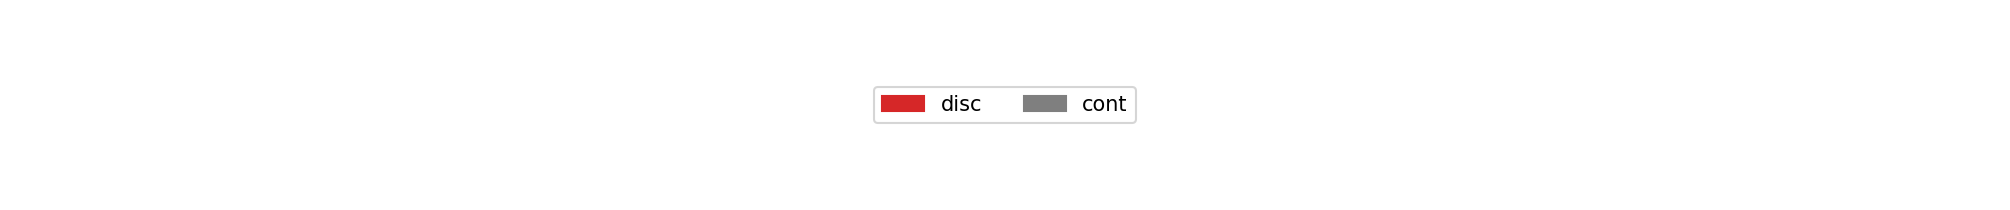

In [245]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [246]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [247]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [248]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

In [249]:
acc

{'sex': 0.61, 'relation': 0.22, 'is_parent': 0.74, 'has_pets': 0.95}

In [250]:
rmse

{'age': 10.91, 'mean_tr': 6961.1, 'median_tr': 6271.59, 'tr_per_month': 18.89}

In [251]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [252]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 17.630965225294098
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.4 min
Best metric is 17.630965225294098
Generation num: 1
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.6 min
Best metric is 11.750813567632552
Generation num: 2
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.9 min
Best metric is 11.750813567632552
Generation num: 3
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please c

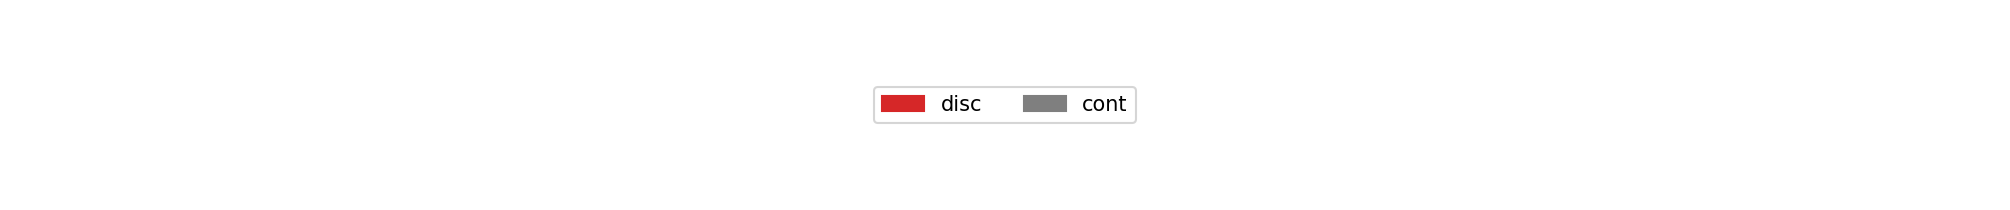

In [253]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [254]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [255]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [256]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

In [257]:
acc

{'sex': 0.61, 'relation': 0.22, 'is_parent': 0.74, 'has_pets': 0.95}

In [258]:
rmse

{'age': 12.44, 'mean_tr': 3332.17, 'median_tr': 6246.19, 'tr_per_month': 19.13}

In [259]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная структура + дискретные параметры

In [260]:
geo_new_types = {'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'disc',
 'mean_tr': 'disc',
 'median_tr': 'disc',
 'tr_per_month': 'disc'}

In [261]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 4.7853
Generation num: 0
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 4.785299999999999
Generation num: 1
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 4.785299999999999
Generation num: 2
max_depth: 3, no improvements: 2
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 4.785299999999999
Generation num: 3
max_depth: 3, no improvements: 3
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_

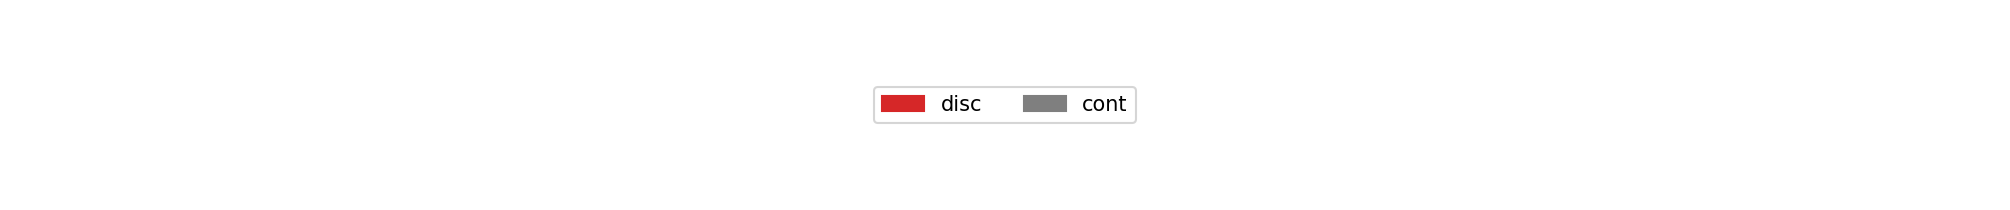

In [262]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [263]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [264]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [265]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [266]:
acc

{'sex': 0.61,
 'relation': 0.24,
 'is_parent': 0.74,
 'has_pets': 0.95,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [267]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [268]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [269]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [270]:
m = mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'age', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [271]:
m = mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'mean_tr', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [272]:
m = mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'median_tr', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [273]:
m = mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'tr_per_month', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [274]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 21.79503585320658
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.4 min
Best metric is 12.005837830951897
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.6 min
Best metric is 11.771364583521681
Generation num: 2
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.8 min
Best metric is 11.771364583521681
Generation num: 3
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attri

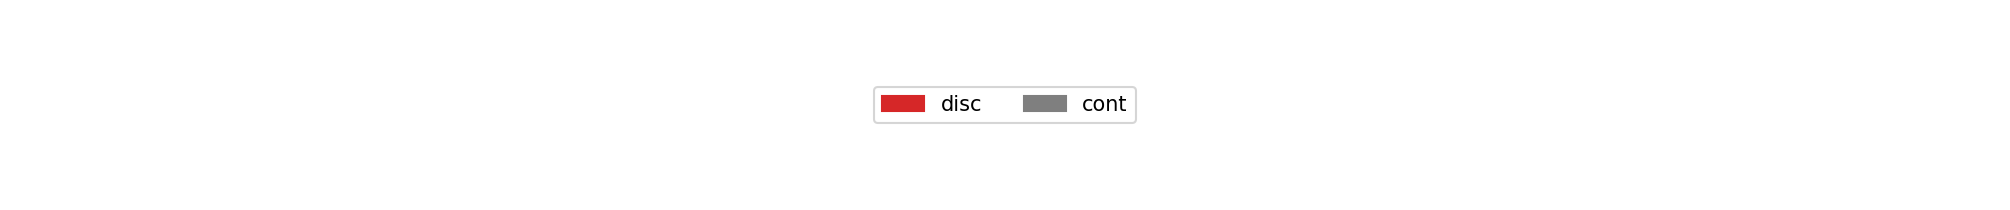

In [275]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [276]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [277]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [278]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [279]:
acc

{'sex': 0.61,
 'relation': 0.22,
 'is_parent': 0.74,
 'has_pets': 0.95,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [280]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [281]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [282]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [283]:
m = mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'age', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [284]:
m = mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'mean_tr', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [285]:
m = mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'median_tr', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [286]:
m = mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'tr_per_month', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [287]:
df_result_accuracy.to_csv('socio_results_disc.csv', index=False)
df_result_rmse.to_csv('socio_results_cont.csv', index=False)